# Act 1: The Problem

## The Diagnostic Odyssey

> "Patients with autoimmune diseases wait an average of 4-7 years for diagnosis. During that time, symptoms are often dismissed as stress, anxiety, or isolated issues."

---

### Key Findings

1. **88,742 patients** across 11 disease clusters in our dataset
2. **Significant lab marker differences** between healthy and autoimmune patients
3. **Class imbalance** challenges: healthy (42%) vs autoimmune clusters
4. **Overlapping symptoms** make single-marker diagnosis unreliable
5. **Z-score normalization** reveals hidden patterns

---

In [1]:
import sys
from pathlib import Path

src_path = Path('../src').resolve()
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from visualization.style import apply_aura_style, PALETTE, C, CATEGORY_COLOR, CAT_COLORS
from visualization.style import AURA_DIVERGING, AURA_SEQUENTIAL, AURA_TEAL, AURA_RDYLGN
apply_aura_style()

Path('../outputs/figures').mkdir(parents=True, exist_ok=True)

# ── Clean label helpers ───────────────────────────────────────────────────────
LAB_LABELS = {
    'wbc': 'WBC', 'rbc': 'RBC', 'hemoglobin': 'Hemoglobin',
    'hematocrit': 'Hematocrit', 'platelet_count': 'Platelet Count',
    'mcv': 'MCV', 'mch': 'MCH', 'rdw': 'RDW', 'esr': 'ESR', 'crp': 'CRP',
    'age': 'Age', 'bmi': 'BMI',
    'wbc_zscore': 'WBC Z-Score', 'rbc_zscore': 'RBC Z-Score',
    'hemoglobin_zscore': 'Hemoglobin Z-Score', 'hematocrit_zscore': 'Hematocrit Z-Score',
    'platelet_count_zscore': 'Platelet Count Z-Score',
    'mcv_zscore': 'MCV Z-Score', 'mch_zscore': 'MCH Z-Score',
    'rdw_zscore': 'RDW Z-Score', 'esr_zscore': 'ESR Z-Score', 'crp_zscore': 'CRP Z-Score',
}
CLUSTER_LABELS = {
    'healthy': 'Healthy', 'systemic': 'Systemic',
    'gastrointestinal': 'Gastrointestinal', 'endocrine': 'Endocrine',
    'neurological': 'Neurological', 'dermatological': 'Dermatological',
    'haematological': 'Haematological', 'renal': 'Renal',
    'pulmonary': 'Pulmonary', 'ophthalmic': 'Ophthalmic',
    'other_autoimmune': 'Other Autoimmune',
}

def clean_label(s):
    """Convert raw column name to a presentation-ready label."""
    return LAB_LABELS.get(s, CLUSTER_LABELS.get(s, s.replace('_', ' ').title()))

# Shared box plot style props
BOXPLOT_PROPS = dict(
    patch_artist=True,
    flierprops=dict(marker='o', markerfacecolor=C['text'], markeredgecolor=C['border'],
                    markersize=3, linestyle='none', alpha=0.55),
    medianprops=dict(color=C['accent'], linewidth=2.0),
    whiskerprops=dict(color=C['muted'], linewidth=1.2),
    capprops=dict(color=C['muted'], linewidth=1.2),
    boxprops=dict(linewidth=1.2),
)

priority_clusters = ['healthy', 'systemic', 'gastrointestinal', 'endocrine']
cluster_colors = CATEGORY_COLOR   # use Aura palette

print('Setup complete!')

Setup complete!


In [2]:
import sys, os                                                        
sys.path.insert(0, r"C:\Users\domdd\Documents\GitHub\aura\modeling\src")                     
import data.loaders as loaders                                        
                                                                    
print("PROJECT_ROOT:", loaders.PROJECT_ROOT)                          
print("DATA_DIR:", loaders.DATA_DIR)  

PROJECT_ROOT: C:\Users\domdd\Documents\GitHub\aura\modeling
DATA_DIR: C:\Users\domdd\Documents\GitHub\aura\modeling\data\processed


In [3]:
# Load data
from data.loaders import load_core_matrix, load_modeling_data, get_cluster_labels

df = load_modeling_data()
print(f'Total patients: {len(df):,}')
print(f'Features: {len(df.columns)}')
print(f'\nData loaded successfully!')
df.head()

Total patients: 48,770
Features: 50

Data loaded successfully!


,patient_id,source,age,sex,esr,crp,diagnosis_raw,diagnosis_icd10,diagnosis_cluster,mch,...,rf_status,anti_ccp,ana_status,anti_dsdna,hla_b27,anti_sm,anti_ro,anti_la,c3,c4
0,harvard_00000,harvard,70.0,M,39.0,18.60,Rheumatoid Arthritis,M06.9,systemic,NaN,...,34.2,29.9,0.0,1.0,1.0,1.0,1.0,0.0,NaN,27.0
1,harvard_00001,harvard,39.0,F,26.0,21.70,Rheumatoid Arthritis,M06.9,systemic,NaN,...,35.5,28.9,NaN,1.0,0.0,NaN,1.0,NaN,100.0,66.0
2,harvard_00002,harvard,36.0,F,41.0,15.60,Rheumatoid Arthritis,M06.9,systemic,NaN,...,21.3,21.3,0.0,0.0,0.0,NaN,NaN,1.0,158.0,12.0
3,harvard_00003,harvard,35.0,M,43.0,23.40,Rheumatoid Arthritis,M06.9,systemic,NaN,...,26.0,39.0,NaN,NaN,NaN,NaN,1.0,1.0,119.0,41.0
4,harvard_00004,harvard,37.0,F,30.0,14.86,Rheumatoid Arthritis,M06.9,systemic,NaN,...,38.1,30.8,0.0,1.0,1.0,0.0,1.0,0.0,144.0,49.0


## 1. The Scale of Autoimmune Disease

Autoimmune diseases affect approximately 10% of the global population. Our dataset captures patients across 11 distinct disease clusters.

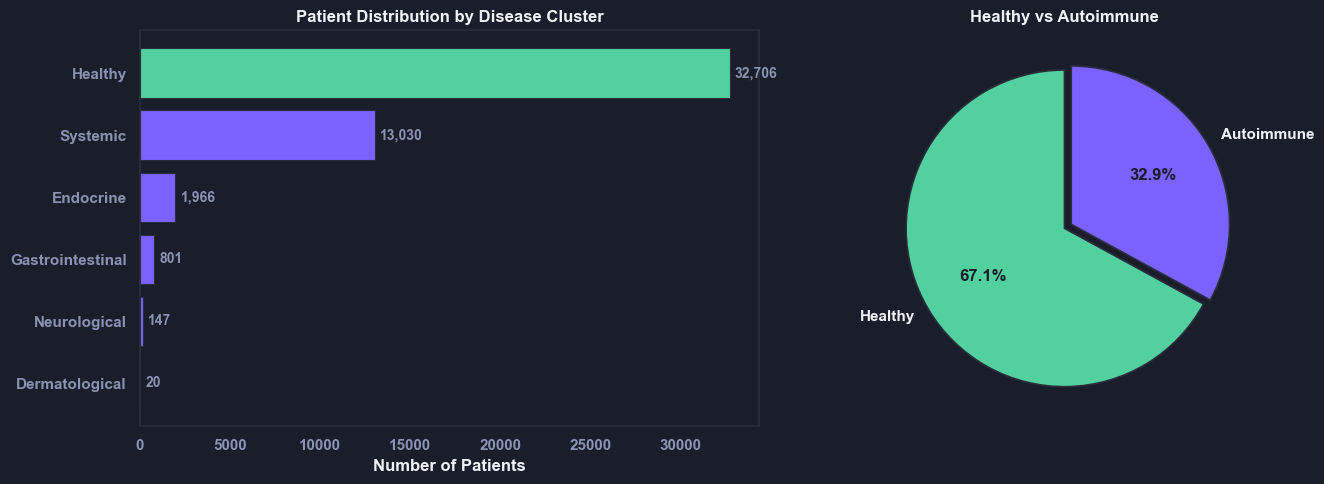


Healthy controls: 32,706 (67.1%)
Autoimmune patients: 16,064 (32.9%)


In [4]:
# Disease cluster distribution
cluster_counts = df['diagnosis_cluster'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.patch.set_facecolor(C['card'])

# Bar chart
bar_colors = [C['success'] if c == 'healthy' else C['primary'] for c in cluster_counts.index]
bars = axes[0].barh(
    [clean_label(c) for c in cluster_counts.index],
    cluster_counts.values,
    color=bar_colors, edgecolor=C['border'], linewidth=0.8,
)
axes[0].set_xlabel('Number of Patients', color=C['text'], fontweight='bold')
axes[0].set_title('Patient Distribution by Disease Cluster',
                  color=C['text'], fontweight='bold')
axes[0].invert_yaxis()
axes[0].set_facecolor(C['card'])
axes[0].tick_params(colors=C['muted'])
for spine in axes[0].spines.values():
    spine.set_edgecolor(C['border'])

for i, v in enumerate(cluster_counts.values):
    axes[0].text(v + 300, i, f'{v:,}', va='center',
                 color=C['muted'], fontsize=10, fontweight='bold')

# Pie chart
autoimmune_count = len(df[df['diagnosis_cluster'] != 'healthy'])
healthy_count    = len(df[df['diagnosis_cluster'] == 'healthy'])

wedges, texts, autotexts = axes[1].pie(
    [healthy_count, autoimmune_count],
    labels=['Healthy', 'Autoimmune'],
    colors=[C['success'], C['primary']],
    autopct='%1.1f%%',
    startangle=90,
    explode=(0, 0.05),
    wedgeprops=dict(edgecolor=C['border'], linewidth=1.2),
)
for t in texts:
    t.set_color(C['text']); t.set_fontweight('bold')
for at in autotexts:
    at.set_color(C['card']); at.set_fontweight('bold')

axes[1].set_title('Healthy vs Autoimmune', color=C['text'], fontweight='bold')
axes[1].set_facecolor(C['card'])

plt.tight_layout()
plt.savefig('../outputs/figures/01_cluster_distribution.png', dpi=150, bbox_inches='tight',
            facecolor=C['card'])
plt.show()

print(f'\nHealthy controls: {healthy_count:,} ({healthy_count/len(df)*100:.1f}%)')
print(f'Autoimmune patients: {autoimmune_count:,} ({autoimmune_count/len(df)*100:.1f}%)')

## 2. Demographics: Who Gets Autoimmune Disease?

Autoimmune diseases disproportionately affect women. Understanding demographic patterns is crucial for fair model development.

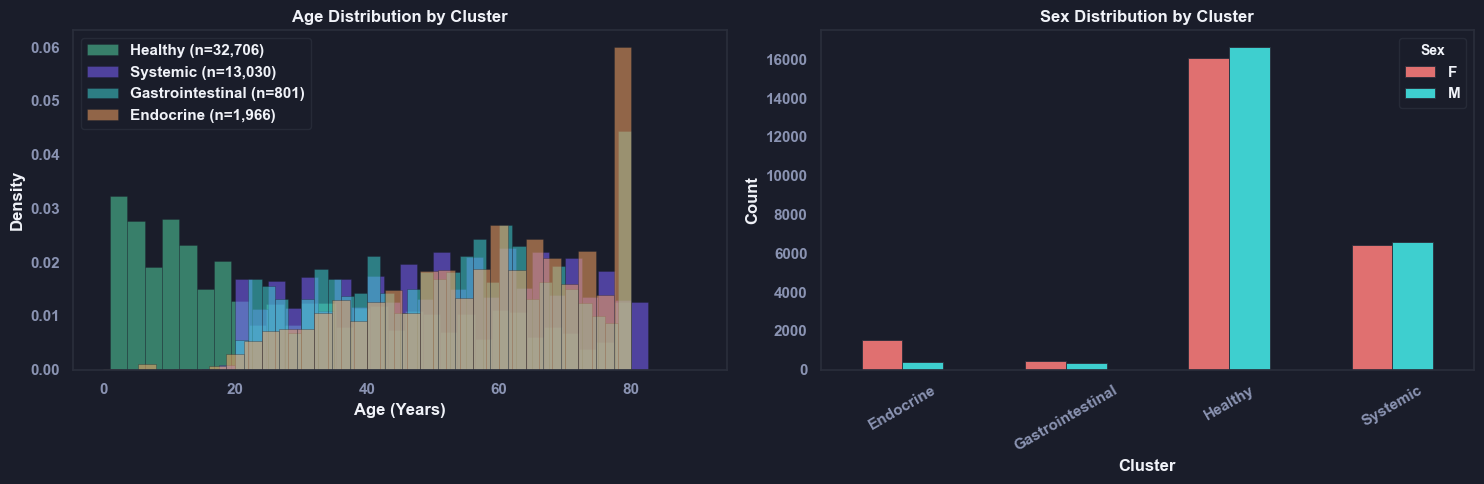

In [5]:
# Demographics by cluster
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.patch.set_facecolor(C['card'])
df_priority = df[df['diagnosis_cluster'].isin(priority_clusters)]

# Age distribution
for cluster in priority_clusters:
    subset = df_priority[df_priority['diagnosis_cluster'] == cluster]['age'].dropna()
    if len(subset) > 0:
        axes[0].hist(subset, bins=30, alpha=0.55,
                     label=f'{clean_label(cluster)} (n={len(subset):,})',
                     color=cluster_colors.get(cluster), density=True,
                     edgecolor=C['card'], linewidth=0.4)

axes[0].set_xlabel('Age (Years)', color=C['text'], fontweight='bold')
axes[0].set_ylabel('Density', color=C['text'], fontweight='bold')
axes[0].set_title('Age Distribution by Cluster', color=C['text'], fontweight='bold')
axes[0].legend(facecolor=C['card'], edgecolor=C['border'], labelcolor=C['text'])
axes[0].set_facecolor(C['card'])
axes[0].tick_params(colors=C['muted'])
for spine in axes[0].spines.values():
    spine.set_edgecolor(C['border'])

# Sex distribution
sex_by_cluster = df_priority.groupby(['diagnosis_cluster', 'sex']).size().unstack(fill_value=0)
sex_by_cluster.index = [clean_label(i) for i in sex_by_cluster.index]
sex_by_cluster.plot(kind='bar', ax=axes[1],
                    color=[C['error'], C['teal']], edgecolor=C['border'], linewidth=0.6)
axes[1].set_xlabel('Cluster', color=C['text'], fontweight='bold')
axes[1].set_ylabel('Count', color=C['text'], fontweight='bold')
axes[1].set_title('Sex Distribution by Cluster', color=C['text'], fontweight='bold')
axes[1].legend(title='Sex', facecolor=C['card'], edgecolor=C['border'],
               labelcolor=C['text'], title_fontsize=10)
axes[1].tick_params(axis='x', rotation=30, colors=C['muted'])
axes[1].tick_params(axis='y', colors=C['muted'])
axes[1].set_facecolor(C['card'])
for spine in axes[1].spines.values():
    spine.set_edgecolor(C['border'])

plt.tight_layout()
plt.savefig('../outputs/figures/01_demographics.png', dpi=150, bbox_inches='tight',
            facecolor=C['card'])
plt.show()

## 3. The Signal in Lab Values

CBC and inflammatory markers show clear differences between healthy and autoimmune patients - but the overlap is significant, making single-marker diagnosis unreliable.

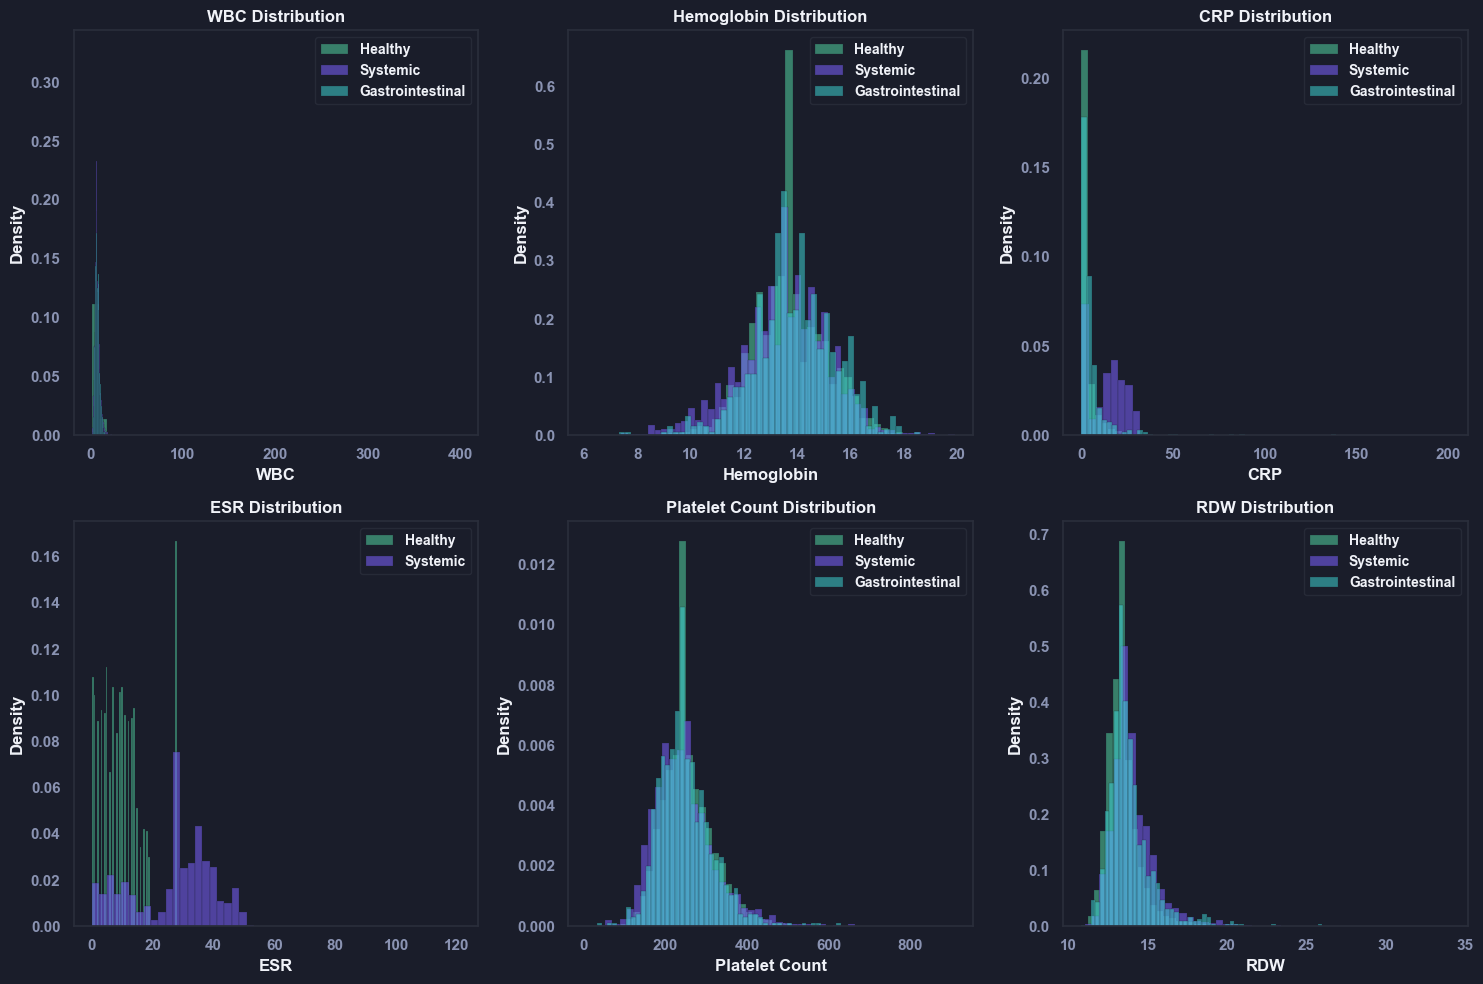

In [6]:
# Key lab markers comparison
lab_markers = ['wbc', 'hemoglobin', 'crp', 'esr', 'platelet_count', 'rdw']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.patch.set_facecolor(C['card'])
axes = axes.flatten()

for idx, marker in enumerate(lab_markers):
    ax = axes[idx]
    ax.set_facecolor(C['card'])
    for spine in ax.spines.values():
        spine.set_edgecolor(C['border'])

    for cluster in ['healthy', 'systemic', 'gastrointestinal']:
        subset = df[df['diagnosis_cluster'] == cluster][marker].dropna()
        if len(subset) > 0:
            ax.hist(subset, bins=50, alpha=0.55,
                    label=clean_label(cluster),
                    color=cluster_colors.get(cluster), density=True,
                    edgecolor=C['card'], linewidth=0.3)

    ax.set_xlabel(clean_label(marker), color=C['text'], fontweight='bold')
    ax.set_ylabel('Density', color=C['text'], fontweight='bold')
    ax.set_title(f'{clean_label(marker)} Distribution', color=C['text'], fontweight='bold')
    ax.legend(facecolor=C['card'], edgecolor=C['border'], labelcolor=C['text'], fontsize=10)
    ax.tick_params(colors=C['muted'])

plt.tight_layout()
plt.savefig('../outputs/figures/01_lab_distributions.png', dpi=150, bbox_inches='tight',
            facecolor=C['card'])
plt.show()

In [7]:
# Statistical comparison: Healthy vs Autoimmune
df['is_autoimmune'] = df['diagnosis_cluster'] != 'healthy'

print('Lab Marker Comparison: Healthy vs Autoimmune')
print('=' * 70)

stats_data = []
for marker in lab_markers:
    healthy = df[df['is_autoimmune'] == False][marker].dropna()
    autoimmune = df[df['is_autoimmune'] == True][marker].dropna()
    
    stats_data.append({
        'Marker': marker.upper(),
        'Healthy Mean': f'{healthy.mean():.2f}',
        'Healthy Std': f'{healthy.std():.2f}',
        'Autoimmune Mean': f'{autoimmune.mean():.2f}',
        'Autoimmune Std': f'{autoimmune.std():.2f}',
        'Diff': f'{autoimmune.mean() - healthy.mean():+.2f}'
    })

pd.DataFrame(stats_data)

Lab Marker Comparison: Healthy vs Autoimmune


,Marker,Healthy Mean,Healthy Std,Autoimmune Mean,Autoimmune Std,Diff
0,WBC,7.24,3.14,7.53,2.72,+0.29
1,HEMOGLOBIN,13.65,1.40,13.52,1.59,-0.13
2,CRP,3.16,6.57,12.95,10.83,+9.80
3,ESR,9.98,7.65,26.92,13.83,+16.93
4,PLATELET_COUNT,255.69,63.88,246.26,73.53,-9.43
5,RDW,13.43,1.18,13.95,1.53,+0.52


## 4. Z-Scores Reveal Hidden Patterns

Raw lab values vary by age and sex. Z-scores normalize against healthy baselines, revealing true deviations.

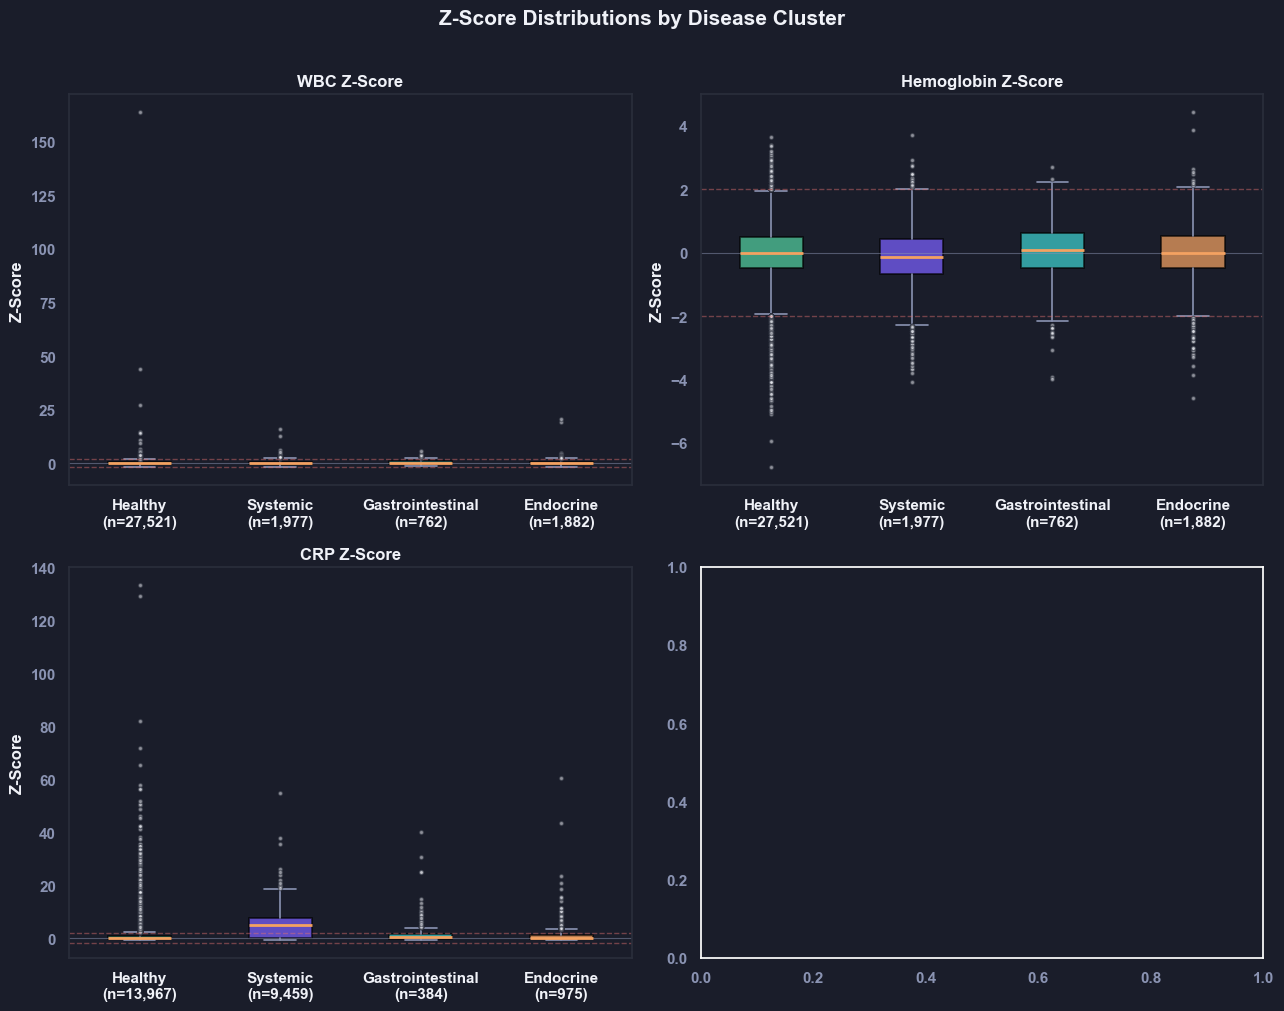

In [8]:
# Z-score box plots by cluster
zscore_cols = ['wbc_zscore', 'hemoglobin_zscore', 'crp_zscore', 'esr_zscore']
zscore_cols = [c for c in zscore_cols if c in df.columns]

if zscore_cols:
    fig, axes = plt.subplots(2, 2, figsize=(13, 10))
    fig.patch.set_facecolor(C['card'])
    axes = axes.flatten()

    fig.suptitle('Z-Score Distributions by Disease Cluster',
                 color=C['text'], fontsize=15, fontweight='bold', y=1.01)

    for idx, col in enumerate(zscore_cols[:4]):
        ax = axes[idx]
        ax.set_facecolor(C['card'])
        for spine in ax.spines.values():
            spine.set_edgecolor(C['border'])

        data, tick_labels, box_colors = [], [], []
        for cluster in priority_clusters:
            subset = df[df['diagnosis_cluster'] == cluster][col].dropna()
            if len(subset) > 0:
                data.append(subset)
                tick_labels.append(f'{clean_label(cluster)}\n(n={len(subset):,})')
                box_colors.append(cluster_colors.get(cluster, C['muted']))

        bp = ax.boxplot(data, labels=tick_labels, **BOXPLOT_PROPS)

        for patch, color in zip(bp['boxes'], box_colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.72)

        # ±2 SD reference lines
        ax.axhline(y=0,  color=C['muted'],  linestyle='-',  linewidth=0.8, alpha=0.5)
        ax.axhline(y=2,  color=C['error'],  linestyle='--', linewidth=1.0, alpha=0.45)
        ax.axhline(y=-2, color=C['error'],  linestyle='--', linewidth=1.0, alpha=0.45)

        ax.set_ylabel('Z-Score', color=C['text'], fontweight='bold')
        ax.set_title(f'{clean_label(col)}', color=C['text'], fontweight='bold')
        ax.tick_params(colors=C['muted'])
        ax.xaxis.set_tick_params(labelcolor=C['text'])

    plt.tight_layout()
    plt.savefig('../outputs/figures/01_zscore_boxplots.png', dpi=150, bbox_inches='tight',
                facecolor=C['card'])
    plt.show()
else:
    print('No z-score columns available')

## 5. Feature Correlations

Understanding how features correlate helps us build better models and avoid multicollinearity.

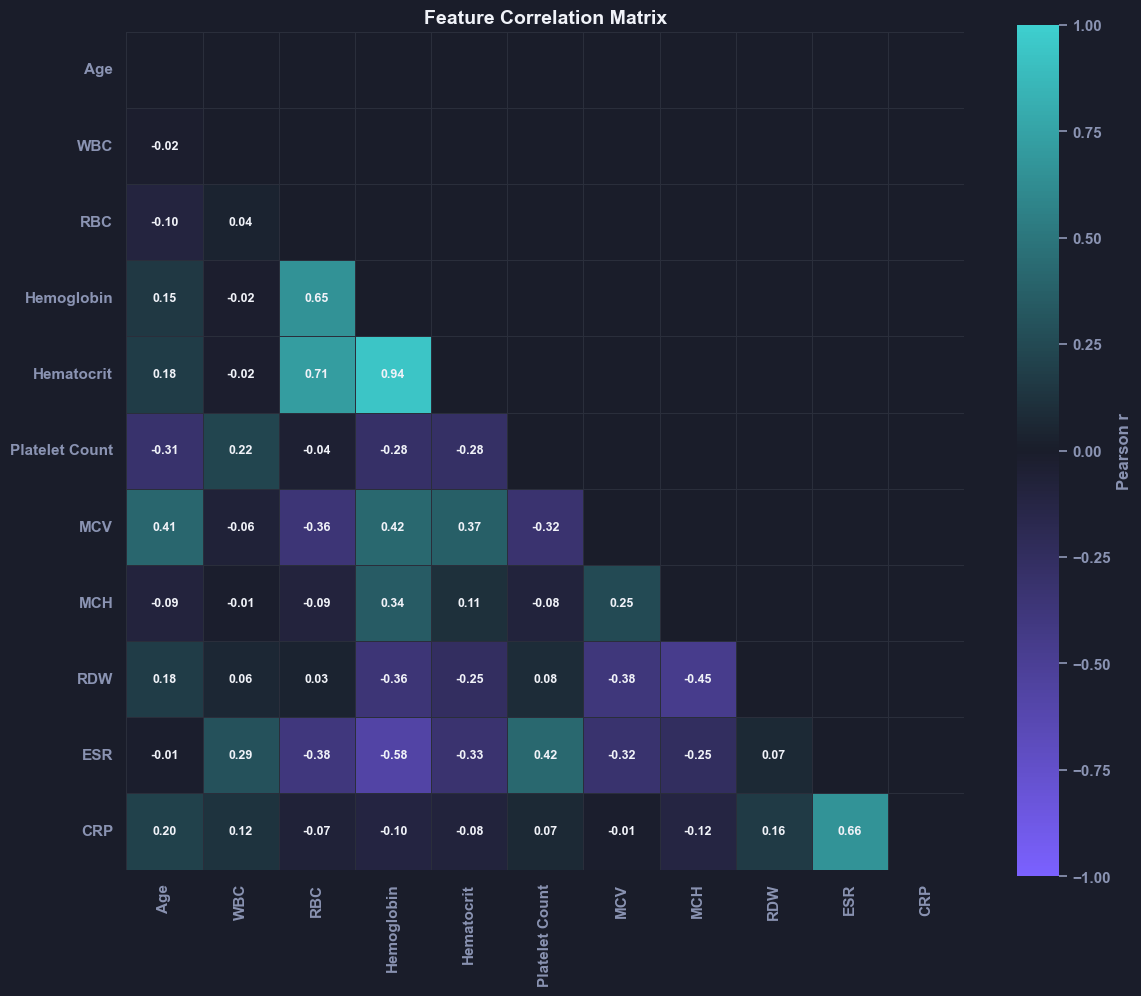

In [9]:
# Correlation heatmap for key features
numeric_features = ['age', 'bmi', 'wbc', 'rbc', 'hemoglobin', 'hematocrit',
                    'platelet_count', 'mcv', 'mch', 'rdw', 'esr', 'crp']
available_features = [f for f in numeric_features if f in df.columns]

corr_matrix = df[available_features].corr()
clean_cols  = [clean_label(f) for f in available_features]
corr_matrix.index   = clean_cols
corr_matrix.columns = clean_cols

fig, ax = plt.subplots(figsize=(12, 10))
fig.patch.set_facecolor(C['card'])
ax.set_facecolor(C['card'])

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f',
            cmap=AURA_DIVERGING, center=0, vmin=-1, vmax=1,
            square=True, linewidths=0.5, linecolor=C['border'],
            ax=ax,
            annot_kws={'color': C['text'], 'fontsize': 9, 'fontweight': 'bold'},
            cbar_kws={'label': 'Pearson r'})

ax.set_title('Feature Correlation Matrix', color=C['text'], fontsize=14, fontweight='bold')
ax.tick_params(colors=C['muted'])
ax.collections[0].colorbar.ax.tick_params(colors=C['muted'])
ax.collections[0].colorbar.set_label('Pearson r', color=C['muted'])

plt.tight_layout()
plt.savefig('../outputs/figures/01_correlation_matrix.png', dpi=150, bbox_inches='tight',
            facecolor=C['card'])
plt.show()

## 6. Data Source Distribution

Our data comes from multiple sources, each contributing different types of patients.

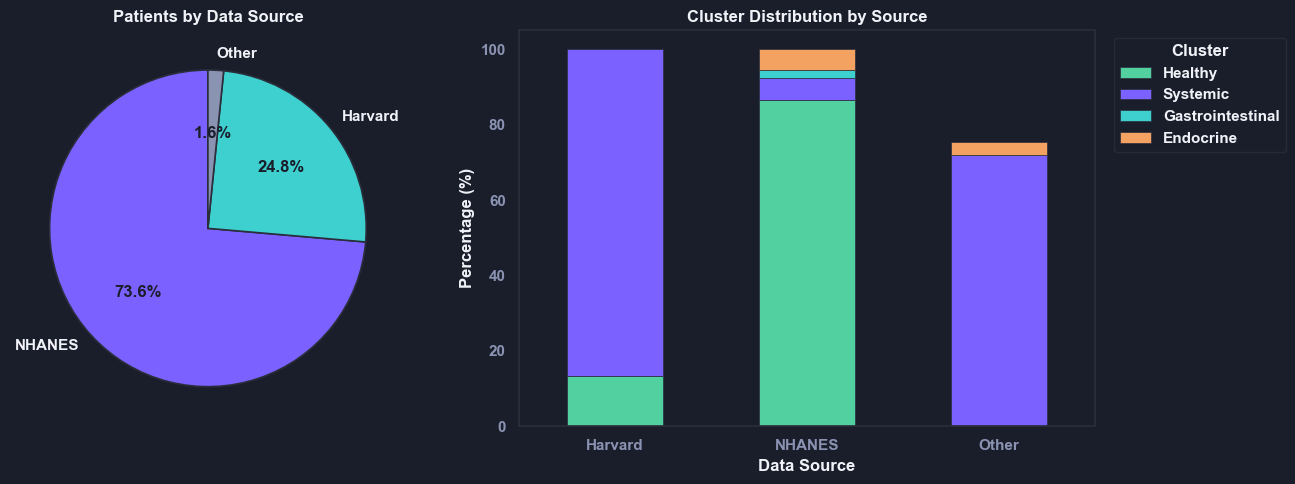


Sample counts by source group:
  NHANES: 35,909
  Harvard: 12,085
  Other: 776


In [10]:
# Source breakdown — consolidate to Harvard / NHANES / Other
def simplify_source(s):
    if 'harvard' in s.lower():    return 'Harvard'
    if 'nhanes'  in s.lower():    return 'NHANES'
    return 'Other'

df['source_grouped'] = df['source'].map(simplify_source)
source_counts = df['source_grouped'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.patch.set_facecolor(C['card'])

# Pie chart
src_colors = [C['primary'], C['teal'], C['muted']][:len(source_counts)]
wedges, texts, autotexts = axes[0].pie(
    source_counts.values,
    labels=source_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=src_colors,
    wedgeprops=dict(edgecolor=C['border'], linewidth=1.2),
)
for t in texts:
    t.set_color(C['text']); t.set_fontweight('bold')
for at in autotexts:
    at.set_color(C['card']); at.set_fontweight('bold')
axes[0].set_title('Patients by Data Source', color=C['text'], fontweight='bold')
axes[0].set_facecolor(C['card'])

# Stacked bar — cluster breakdown per source group
source_cluster = pd.crosstab(df['source_grouped'], df['diagnosis_cluster'], normalize='index') * 100
source_cluster = source_cluster[[c for c in priority_clusters if c in source_cluster.columns]]
source_cluster.columns = [clean_label(c) for c in source_cluster.columns]

source_cluster.plot(kind='bar', stacked=True, ax=axes[1],
                    color=[cluster_colors[c] for c in priority_clusters if c in cluster_colors],
                    edgecolor=C['border'], linewidth=0.5)
axes[1].set_xlabel('Data Source', color=C['text'], fontweight='bold')
axes[1].set_ylabel('Percentage (%)', color=C['text'], fontweight='bold')
axes[1].set_title('Cluster Distribution by Source', color=C['text'], fontweight='bold')
axes[1].legend(title='Cluster', bbox_to_anchor=(1.02, 1),
               facecolor=C['card'], edgecolor=C['border'], labelcolor=C['text'])
axes[1].tick_params(axis='x', rotation=0, colors=C['muted'])
axes[1].tick_params(axis='y', colors=C['muted'])
axes[1].set_facecolor(C['card'])
for spine in axes[1].spines.values():
    spine.set_edgecolor(C['border'])

plt.tight_layout()
plt.savefig('../outputs/figures/01_source_distribution.png', dpi=150, bbox_inches='tight',
            facecolor=C['card'])
plt.show()

print('\nSample counts by source group:')
for source, count in source_counts.items():
    print(f'  {source}: {count:,}')

## 7. Summary Statistics

In [11]:
# Summary
print('=' * 70)
print('DATASET SUMMARY')
print('=' * 70)
print(f'Total patients: {len(df):,}')
print(f'Healthy controls: {healthy_count:,} ({healthy_count/len(df)*100:.1f}%)')
print(f'Autoimmune patients: {autoimmune_count:,} ({autoimmune_count/len(df)*100:.1f}%)')
print(f'\nAge range: {df["age"].min():.0f} - {df["age"].max():.0f} years')
print(f'Mean age: {df["age"].mean():.1f} years (SD: {df["age"].std():.1f})')
print(f'\nSex: {(df["sex"]=="F").sum():,} Female ({(df["sex"]=="F").mean()*100:.1f}%), '
      f'{(df["sex"]=="M").sum():,} Male ({(df["sex"]=="M").mean()*100:.1f}%)')
print(f'\nData sources: {df["source"].nunique()}')
print(f'Disease clusters: {df["diagnosis_cluster"].nunique()}')

DATASET SUMMARY
Total patients: 48,770
Healthy controls: 32,706 (67.1%)
Autoimmune patients: 16,064 (32.9%)

Age range: 0 - 91 years
Mean age: 37.9 years (SD: 23.9)

Sex: 24,680 Female (50.6%), 24,090 Male (49.4%)

Data sources: 17
Disease clusters: 6


---

## Key Takeaways for Modeling

1. **Class imbalance**: Need stratified sampling and appropriate metrics (AUC, not accuracy)
2. **Feature overlap**: Single markers insufficient - need multi-feature models
3. **Z-scores are powerful**: Normalize for age/sex effects
4. **Inflammatory markers**: Key predictors for classification
5. **Source effects**: Consider source as a covariate or stratification variable

---

*Next: Comprehensive Analysis (02_comprehensive_analysis.ipynb)*